### Quick wind-field and setup estimate for Beryl at E. Matagorda Bay
This code, mostly from ChatGPT, reads storm data for Beryl from the IBTRACS database.  
Then it uses a simple Rankine vortex model to estimate the windfield, bases on intensity and raduis of max. winds, plus translation.  
Makes a plot of that, then uses metrics for E. Matagorda Bay to estimate setup.

Using wind_col: USA_WIND
Using rmw_col : USA_RMW
Fix used: 2024-07-08 06:00:00+00:00 center: (28.2, -95.9) vmax_kt: 70.0 rmw_nm: 25.0


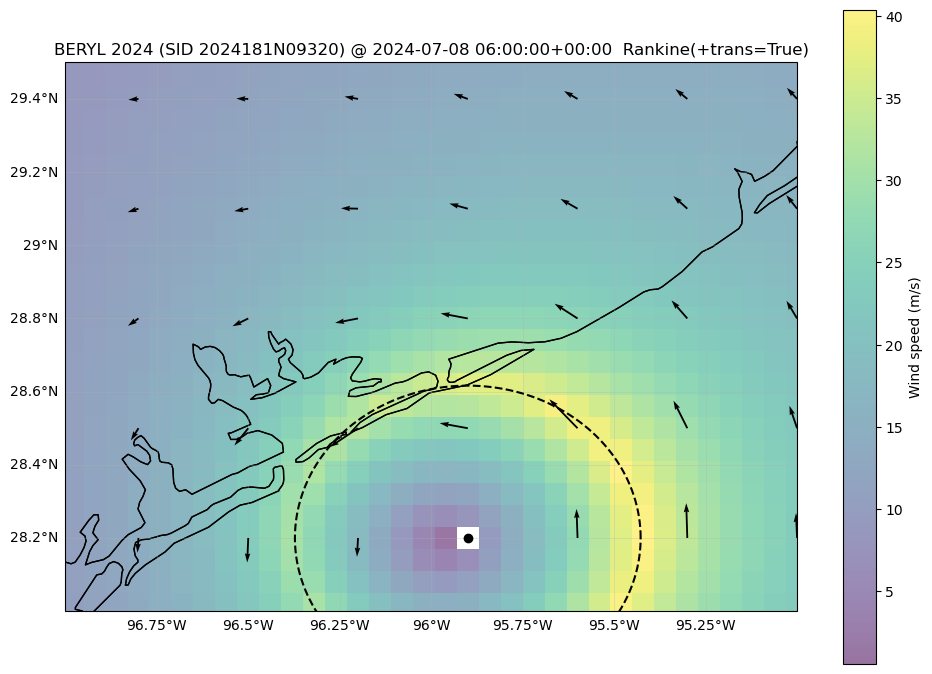

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# pathname to ibtracs filename
IBTRACS_CSV = r"ibtracs.NA.list.v04r01.csv"
SID = "2024181N09320"  # from examination of ibtracs file

# Choose one of your landfall-ish fixes:
TARGET_UTC = "2024-07-08 06:00:00+00:00"  # or 
#TARGET_UTC = "2024-07-08 08:40:00+00:00"  # or 
#TARGET_UTC = "2024-07-08 09:00:00+00:00"
#TARGET_UTC = "2024-07-08 12:00:00+00:00"

DLAT, DLON, NGRID = 3.0, 3.0, 101
ALPHA_OUTER = 1.0

USE_TRANSLATION = True # This adds storm movement to wind field
BETA_TRANSLATION = 1.0 # This determines decay of outer wind field

KT_TO_MS = 0.514444
NM_TO_M  = 1852.0
R_EARTH  = 6371000.0

# -----------------------------
# Helpers
# -----------------------------
def haversine_m(lat1, lon1, lat2, lon2):
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2.0 * R_EARTH * np.arcsin(np.sqrt(a))

def bearing_deg(lat1, lon1, lat2, lon2):
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    brng = np.rad2deg(np.arctan2(x, y))
    return (brng + 360.0) % 360.0

def heading_to_unit_EN(heading_deg):
    th = np.deg2rad(heading_deg)
    return np.sin(th), np.cos(th)

def rankine_speed(Vmax_ms, r_m, rmw_m, alpha_outer=1.0):
    if (rmw_m <= 0) or (r_m <= 0) or np.isnan(rmw_m) or np.isnan(r_m) or np.isnan(Vmax_ms):
        return np.nan
    if r_m <= rmw_m:
        return Vmax_ms * (r_m / rmw_m)
    return Vmax_ms * (rmw_m / r_m)**alpha_outer

def wind_field_rankine(latc, lonc, Vmax_ms, rmw_m, LAT, LON,
                       trans_ms=0.0, trans_heading_deg=0.0,
                       beta_translation=1.0, alpha_outer=1.0, hemisphere="NH"):
    r_m = haversine_m(latc, lonc, LAT, LON)
    br  = np.vectorize(bearing_deg)(latc, lonc, LAT, LON)

    e_r, n_r = heading_to_unit_EN(br)

    if hemisphere.upper() == "NH":
        e_t, n_t = (-n_r, e_r)
    else:
        e_t, n_t = (n_r, -e_r)

    V_tan = np.vectorize(rankine_speed)(Vmax_ms, r_m, rmw_m, alpha_outer)

    e_tr, n_tr = heading_to_unit_EN(trans_heading_deg)
    u_tr = beta_translation * trans_ms * e_tr
    v_tr = beta_translation * trans_ms * n_tr

    u = V_tan * e_t + u_tr
    v = V_tan * n_t + v_tr
    return u, v

def pick_col(df, token, prefer=()):
    cols = [c for c in df.columns if token in c]
    for p in prefer:
        if p in df.columns:
            return p
    return cols[0] if cols else None

# -----------------------------
# Load IBTrACS and select fix
# -----------------------------
df = pd.read_csv(IBTRACS_CSV, skiprows=[1], low_memory=False)
df.columns = df.columns.astype(str).str.strip()

for c in ["SID","NAME","SEASON","ISO_TIME","LAT","LON"]:
    if c not in df.columns:
        raise ValueError(f"Missing required column {c}")

df["SID"] = df["SID"].astype(str).str.strip()
df["ISO_TIME"] = pd.to_datetime(df["ISO_TIME"], errors="coerce", utc=True)
df["LAT"] = pd.to_numeric(df["LAT"], errors="coerce")
df["LON"] = pd.to_numeric(df["LON"], errors="coerce")
df = df.dropna(subset=["SID","ISO_TIME","LAT","LON"])

storm = df[df["SID"] == SID].sort_values("ISO_TIME").copy()
if storm.empty:
    raise ValueError(f"No rows found for SID={SID} in this file.")

# Detect wind and RMW columns available
wind_col = pick_col(storm, "WIND", prefer=("USA_WIND", "WMO_WIND"))
rmw_col  = pick_col(storm, "RMW",  prefer=("USA_RMW",  "WMO_RMW"))

print("Using wind_col:", wind_col)
print("Using rmw_col :", rmw_col)

storm[wind_col] = pd.to_numeric(storm[wind_col], errors="coerce")
storm[rmw_col]  = pd.to_numeric(storm[rmw_col],  errors="coerce")
storm.loc[storm[wind_col].isin([-9999, -999, -99]), wind_col] = np.nan
storm.loc[storm[rmw_col].isin([-9999, -999, -99]),  rmw_col]  = np.nan

# Use closest fix that has both wind and RMW
target = pd.to_datetime(TARGET_UTC, utc=True)
storm2 = storm.dropna(subset=[wind_col, rmw_col]).copy()
idx = (storm2["ISO_TIME"] - target).abs().idxmin()
fix = storm2.loc[idx]

latc, lonc = float(fix["LAT"]), float(fix["LON"])
vmax_kt = float(fix[wind_col])
rmw_nm  = float(fix[rmw_col])
Vmax_ms = vmax_kt * KT_TO_MS
rmw_m   = rmw_nm * NM_TO_M

# Translation estimate from adjacent fixes (optional)
trans_ms, trans_hdg = 0.0, 0.0
if USE_TRANSLATION:
    storm2 = storm2.sort_values("ISO_TIME").reset_index(drop=True)
    k = int((storm2["ISO_TIME"] - fix["ISO_TIME"]).abs().idxmin())
    if 0 < k < len(storm2) - 1:
        prev, nxt = storm2.iloc[k-1], storm2.iloc[k+1]
        dt_s = (nxt["ISO_TIME"].to_datetime64() - prev["ISO_TIME"].to_datetime64()) / np.timedelta64(1, "s")
        if np.isfinite(dt_s) and dt_s > 0:
            d_m = haversine_m(prev["LAT"], prev["LON"], nxt["LAT"], nxt["LON"])
            trans_ms = float(d_m / dt_s)
            trans_hdg = float(bearing_deg(prev["LAT"], prev["LON"], nxt["LAT"], nxt["LON"]))

print("Fix used:", fix["ISO_TIME"], "center:", (latc, lonc), "vmax_kt:", vmax_kt, "rmw_nm:", rmw_nm)

# -----------------------------
# Compute wind grid
# -----------------------------
lats = np.linspace(latc - DLAT, latc + DLAT, NGRID)
lons = np.linspace(lonc - DLON, lonc + DLON, NGRID)
LON, LAT = np.meshgrid(lons, lats)

u, v = wind_field_rankine(
    latc, lonc, Vmax_ms, rmw_m,
    LAT, LON,
    trans_ms=trans_ms,
    trans_heading_deg=trans_hdg,
    beta_translation=BETA_TRANSLATION,
    alpha_outer=ALPHA_OUTER,
    hemisphere="NH"
)
spd = np.hypot(u, v)

# -----------------------------
# Plot on Texas coastline (line drawing)
# -----------------------------
extent = [-97, -95, 28.0, 29.5]
proj = ccrs.PlateCarree()

title_str = f"BERYL 2024 (SID {SID}) @ {fix['ISO_TIME']}  Rankine(+trans={USE_TRANSLATION})"

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=proj)
ax.set_extent(extent, crs=proj)

ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=1.0)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=0.9)

im = ax.pcolormesh(LON, LAT, spd, transform=proj, shading="auto", alpha=0.55)
cbar = plt.colorbar(im, ax=ax, shrink=0.85)
cbar.set_label("Wind speed (m/s)")

step = max(1, NGRID // 18)
ax.quiver(LON[::step, ::step], LAT[::step, ::step],
          u[::step, ::step], v[::step, ::step],
          transform=proj, scale=700, width=0.0025, zorder=5)

ax.plot(lonc, latc, "ko", ms=6, transform=proj, zorder=6)

deg_lat = (rmw_m / R_EARTH) * (180.0 / np.pi)
th = np.linspace(0, 2*np.pi, 361)
ax.plot(lonc + (deg_lat*np.cos(th))/np.cos(np.deg2rad(latc)),
        latc + deg_lat*np.sin(th), "k--", lw=1.5, transform=proj, zorder=6)

gl = ax.gridlines(draw_labels=True, linewidth=0.4, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

ax.set_title(title_str)
plt.tight_layout()

# Be sure to change this file name to agree with time selected above
plt.savefig('Beryl_Matagorda_2024_07_08_0600.jpg')
plt.show()

In [2]:
# Now calculate estimated setup for E. Matagorda Bay
site_lat = 28.700
site_lon = -95.838
L_m      = 26000.0
h_m      = 2.0
az_deg   = 65.0

# Setup constants (same as earlier)
RHO_A = 1.225
RHO_W = 1025.0
G     = 9.81
CD    = 1.5e-3

# Requires wind-field code already in memory:
#   latc, lonc, Vmax_ms, rmw_m, trans_ms, trans_hdg
#   (and wind_field_rankine function)

def angle_diff_deg(a, b):
    return (a - b + 180.0) % 360.0 - 180.0

def heading_to_unit_EN(heading_deg):
    th = np.deg2rad(heading_deg)
    return np.sin(th), np.cos(th)

def EN_to_heading_deg(e, n):
    hdg = np.rad2deg(np.arctan2(e, n))
    return (hdg + 360.0) % 360.0

# -----------------------------
# Compute wind vector at the site (call the same Rankine model)
# -----------------------------
LAT_pt = np.array([[site_lat]])
LON_pt = np.array([[site_lon]])

u_pt, v_pt = wind_field_rankine(
    latc, lonc, Vmax_ms, rmw_m,
    LAT_pt, LON_pt,
    trans_ms=trans_ms,
    trans_heading_deg=trans_hdg,
    beta_translation=BETA_TRANSLATION,
    alpha_outer=ALPHA_OUTER,
    hemisphere="NH"
)

u_pt = float(u_pt[0, 0])  # m/s east
v_pt = float(v_pt[0, 0])  # m/s north
U10  = float(np.hypot(u_pt, v_pt))

wind_dir_to = EN_to_heading_deg(u_pt, v_pt)          # direction wind blows toward (deg from north)
wind_dir_from = (wind_dir_to + 180.0) % 360.0        # meteorological "from"

# -----------------------------
# Cos^2 directional scaling relative to lagoon axis az_deg
# -----------------------------
dtheta = angle_diff_deg(wind_dir_to, az_deg)         # compare TO-direction with lagoon axis
cos2 = float(np.cos(np.deg2rad(dtheta))**2)

# Effective along-axis stress and setup
tau_eff = RHO_A * CD * (U10**2) * cos2
eta_m = (tau_eff * L_m) / (RHO_W * G * h_m)

print("Interpolated/model wind at site:")
print(f"  u_east (m/s): {u_pt:8.3f}")
print(f"  v_north(m/s): {v_pt:8.3f}")
print(f"  U10    (m/s): {U10:8.3f}")
print(f"  dir_to (deg): {wind_dir_to:8.2f}")
print(f"  dir_from(deg): {wind_dir_from:8.2f}")
print("")
print("Directional scaling and setup:")
print(f"  lagoon az_deg      : {az_deg:6.1f}")
print(f"  dtheta (to-az) deg : {dtheta:8.2f}")
print(f"  cos^2 weight       : {cos2:8.4f}")
print(f"  tau_eff (Pa)       : {tau_eff:8.4f}")
print(f"  eta_setup (m)      : {eta_m:8.4f}")


Interpolated/model wind at site:
  u_east (m/s):  -30.595
  v_north(m/s):    8.130
  U10    (m/s):   31.657
  dir_to (deg):   284.88
  dir_from(deg):   104.88

Directional scaling and setup:
  lagoon az_deg      :   65.0
  dtheta (to-az) deg :  -140.12
  cos^2 weight       :   0.5889
  tau_eff (Pa)       :   1.0843
  eta_setup (m)      :   1.4019
